In [1]:
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    BCELoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import real_amplitudes, zz_feature_map
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit_machine_learning.connectors import TorchConnector

estimator = Estimator()
# from qiskit_aer import AerSimulator

# sim = AerSimulator(method="tensor_network", device="GPU", cuStateVec_enable=True)
# print(sim.options)
# Set seed for random generators
algorithm_globals.random_seed = 42

In [3]:
from qiskit.quantum_info import SparsePauliOp

observables = [
    SparsePauliOp.from_list([("ZIII", 1)]),
    SparsePauliOp.from_list([("IZII", 1)]),
    SparsePauliOp.from_list([("IIZI", 1)]),
    SparsePauliOp.from_list([("IIIZ", 1)])
]


In [4]:
# Define and create QNN
def create_qnn():
    feature_map = zz_feature_map(4)
    ansatz = real_amplitudes(4, reps=1)
    qc = QuantumCircuit(4)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        observables=observables,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
        estimator=estimator,
    )
    return qnn


qnn = create_qnn()

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


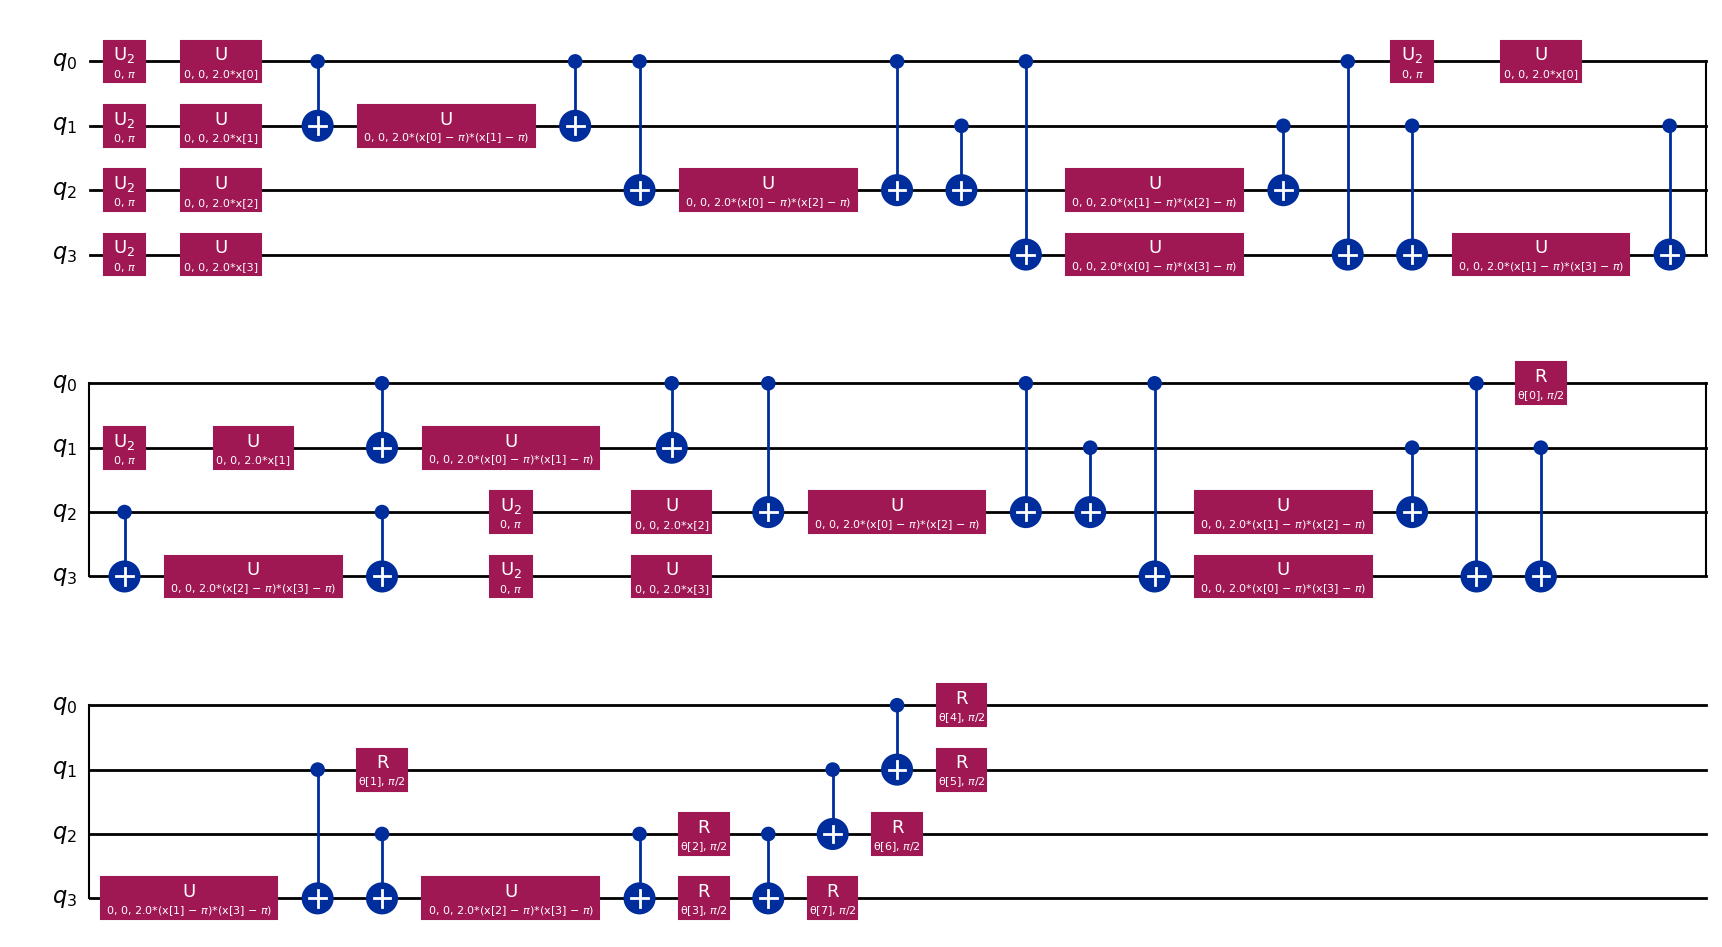

In [5]:
feature_map = zz_feature_map(4)
ansatz = real_amplitudes(4, reps=1)
qc = QuantumCircuit(4)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.decompose().draw("mpl")

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())  
print(torch.cuda.device_count())  
print(torch.cuda.get_device_name(0))
x = torch.randn(10000, 10000, device=device)
y = torch.randn(10000, 10000, device=device)

# z = torch.matmul(x, y)
torch.cuda.synchronize()
print("Computation finished on:", device)

True
1
NVIDIA RTX A6000
Computation finished on: cuda


In [7]:
# Define torch NN module

class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.fc1 = Linear(5, 8)
        self.fc3 = Linear(8, 4)
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        self.fc4 = Linear(4, 1)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc3(x))
        x = self.qnn(x)
        x = torch.sigmoid(self.fc4(x))
        return x


model = Net(qnn).to(device)

In [8]:
import pandas as pd
path = "./Fish.csv"
df = pd.read_csv(path)
print(df.head())


  Species  Weight  Length1  Length2  Length3   Height   Width
0   Bream   242.0     23.2     25.4     30.0  11.5200  4.0200
1   Bream   290.0     24.0     26.3     31.2  12.4800  4.3056
2   Bream   340.0     23.9     26.5     31.1  12.3778  4.6961
3   Bream   363.0     26.3     29.0     33.5  12.7300  4.4555
4   Bream   430.0     26.5     29.0     34.0  12.4440  5.1340


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
X = df.drop(columns=["Species", "Weight"]).values
y = df["Weight"].values.reshape(-1, 1)
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"train_data: {X_train.shape}, val_data: {X_val.shape}, test_data: {X_test.shape}")


train_data: (127, 5), val_data: (16, 5), test_data: (16, 5)


In [11]:
# Transform to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)


In [12]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 2

# dataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [13]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_func = BCELoss().to(device)

# Start training
epochs = 30  # Set number of epochs
loss_list = []  # Store loss history

In [ ]:
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = loss_func(y_pred, y_batch.squeeze())
        loss.backward() 
        optimizer.step() 
        total_loss += loss.item()
    if epoch+1 in [5, 10, 15, 20, 25, 30]:
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

torch.save(model.state_dict(), "./output/qnn_model.pt")
print("Save Model successfully")

Epoch 5/30, Loss: 0.5388
Epoch 10/30, Loss: 0.5008
Epoch 15/30, Loss: 0.4813


In [ ]:
estimator1 = Estimator(options={'backend_options': {"device": "GPU", "cuStateVec_enable": True}})
def create_qnn():
    feature_map = zz_feature_map(4)
    ansatz = real_amplitudes(4, reps=1)
    qc = QuantumCircuit(4)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        observables=observables,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
        estimator=estimator1,
    )
    return qnn


qnn = create_qnn()
model = Net(qnn).to(device)
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = loss_func(y_pred, y_batch.squeeze())
        loss.backward() 
        optimizer.step() 
        total_loss += loss.item()
    if epoch+1 in [5, 10, 15, 20, 25, 30]:
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

torch.save(model.state_dict(), "./output/qnn_model.pt")
print("Save Model successfully")

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Epoch 5/30, Loss: 0.6383
Epoch 10/30, Loss: 0.6389
Epoch 15/30, Loss: 0.6388
Epoch 20/30, Loss: 0.6381
Epoch 25/30, Loss: 0.6388
Epoch 30/30, Loss: 0.6393
Save Model successfully
